# YOLO Example
### To start with, use built-in function in Gluoncv Library to illustrate how YOLO works

In [1]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

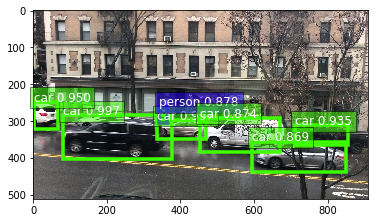

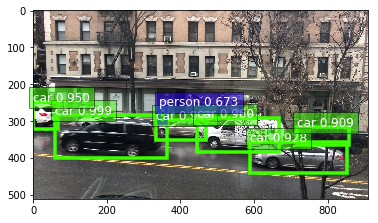

In [2]:
# use yolo mxnet package
num_frames = 228 
for i in range(2):
    x, img = data.transforms.presets.yolo.load_test('cars/' + 'frame' + str(i) + '.jpg', short=512)
    class_IDs, scores, bounding_boxs = net(x)
    ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
    
    # plot with predicted bounding boxes
    # be careful not to plot all frames at once: memory issues
    #plt.savefig('frames/' + 'frame' + str(i) + '.jpg') 

# Project begins here...

In [1]:
# load libraries
import os
import numpy as np
import cv2
#import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import misc
from PIL import Image

### Define functions to 
- extract frames,
- transform coordinates, 
- plot predicted bounding boxes
- save predictions to local
- convert predicted images to video

In [2]:
# extract frames from video
def extractFrames(pathIn, pathOut):
    """
    Input: video from pathIn
    Output: .jpg images to pathOut
    """
    if not os.path.exists(pathOut):
        os.mkdir(pathOut)
    
    # load video
    cap = cv2.VideoCapture(pathIn)
    count = 0
    
    while (cap.isOpened()):
        ret, frame = cap.read() # Capture frame-by-frame
        if ret == True:
            print('Read %d frame: ' % count, ret) #verbose to keep track 
            cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
        else:
            break
    
    # release the capture when everything done
    cap.release()
    cv2.destroyAllWindows()
    
    return count

In [3]:
# transform the raw_input
def transform(raw_input):
    # create offset matrix - ask hans for further detail on transformation
    offset = np.reshape(np.tile(np.arange(7), reps = 7), (7, 7))
    # split confidence score
    confi = raw_input[:, :49]
    confidence = np.reshape(confi, (confi.shape[0], 7, 7, 1))
    # split position info
    position = raw_input[:, 49:49*5]
    position = np.reshape(position, (position.shape[0], 7, 7, 4))
    # split labels info
    labels = raw_input[:, 49*5:]
    labels = np.reshape(labels, (labels.shape[0], 7, 7, 2))
    # change position
    position[..., 2:] = position[..., 2:] ** 2
    position[..., 0] = (position[..., 0] + offset)/7
    position[..., 1] = (position[..., 1] + offset.transpose())/7
    return confidence, position, labels

In [4]:
# plot bounding box
def draw_bbox(image_file, confidence, position, labels, threshold, i):
    """
    Input:
        image_file - str, name of the image
        confidence - list, output of 'transform' function
        position - list, output of 'transform' function
        labels - list, output of 'transform' function
        threshold - floa, the confidence score used to select bounding boxes
        i - int, the index of frame
    Output:
        images with predicted bounding boxes 
    """
    bbox = []
    cell_position = []
    # add the grid [m, n] to the collection of bbox if the confidence score is good enough
    for m in range(7):
        for n in range(7):
            if confidence[i][m][n][0] > threshold:
                bbox.append(position[i][m][n])
    # resize input image
    im = np.array(Image.open(image_file), dtype=np.uint8)
    im = cv2.resize(im, (448,448))
    fig,ax = plt.subplots(1)
    ax.set_title('confidence threshold is %3f' % threshold)
    ax.imshow(im)
    # add every bbox to the image
    for k in range(len(bbox)):
        box = bbox[k]
        xmid = box[0] * 448
        ymid = box[1] * 448
        length = box[2] * 448
        width = box[3] * 448
        rect = patches.Rectangle((xmid - length/2, ymid - width/2), length, width, 
                                 linewidth=1,edgecolor='r',facecolor='none')
        # print(box[1:5])
        ax.add_patch(rect)
    plt.show()  

In [5]:
# save images with predicted bounding boxes to local file
def save_bbox(image_file, confidence, position, labels, threshold, i, pathout):
    """
    Input:
        image_file - str, name of the image
        confidence - list, output of 'transform' function
        position - list, output of 'transform' function
        labels - list, output of 'transform' function
        threshold - floa, the confidence score used to select bounding boxes
        i - int, the index of frame
        pathout - str, the directory to save frames
    Output:
        frame images with predicted bounding boxes in local file
    """
    bbox = []
    cell_position = []
    # add the grid [m, n] to the collection of bbox if the confidence score is good enough
    for m in range(7):
        for n in range(7):
            if confidence[i][m][n][0] > threshold:
                bbox.append(position[i][m][n])
    # resize input image
    im = np.array(Image.open(image_file), dtype=np.uint8)
    im = cv2.resize(im, (448,448))
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    # add every bbox to the image
    for k in range(len(bbox)):
        box = bbox[k]
        xmid = box[0] * 448
        ymid = box[1] * 448
        length = box[2] * 448
        width = box[3] * 448
        rect = patches.Rectangle((xmid - length/2, ymid - width/2), length, width, 
                                 linewidth=1,edgecolor='r',facecolor='none')
        # print(box[1:5])
        ax.add_patch(rect)
    plt.savefig(pathout + '/frame' + str(i) + '_output.jpg') 
    print('frame %d done' % i)
    plt.close()

In [6]:
# convert image to video
def image_to_video(pathout, num_frames):
    """
    Input: str
        pathout - directory to save the output video
        num_frames - the index of last frame that you want to have in the video
    Output: 
        a mp4 video file
    """
    fps = 30
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    outfile = pathout + '_output_video.mp4'
    
    videoWriter = cv2.VideoWriter(outfile, fourcc, fps, (432,288)) 
    for i in range(num_frames-1): 
        img = cv2.imread(pathout + '/frame' + str(i) + '_output.jpg')
        videoWriter.write(img)
        
    # release everything when work is done
    videoWriter.release()

# Working Pipeline

Only edit input file directories in this cell，please don't change other cells

In [7]:
"""
Three input files:

pathin - directory of input video
pathout - directory of output folder with extracted frames
bbox_pred - prediction of bounding boxes
"""
pathin = 'tbbt2.mov' 
pathout = 'tbbt2'
bbox_pred = 'tbbt2_2580train_100epoch.npy'

### You can uncomment the cell below to do a one-click yolo...

In [ ]:
"""
print('Step 1: Extracting frames...')
num_frames = extractFrames(pathin, pathout)

print('Step 2: Transforming coordinates...')
y = np.load(bbox_pred)
confidence, position, labels = transform(y) 

print('Step 3: Saving images to local folder...')
for k in range(num_frames-1): #num_frames
    save_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.16, k, pathout)

print('Step 4: Converting images to video...')
image_to_video(pathout, num_frames)

print('Done! Now open the mp4 file to check out the result.')
"""

### Or you can check out each steps in details and adjust parameters threshold accordingly.

1. Extract frames from video

In [9]:
num_frames = extractFrames(pathin, pathout)

Read 0 frame:  True
Read 1 frame:  True
Read 2 frame:  True
Read 3 frame:  True
Read 4 frame:  True
Read 5 frame:  True
Read 6 frame:  True
Read 7 frame:  True
Read 8 frame:  True
Read 9 frame:  True
Read 10 frame:  True
Read 11 frame:  True
Read 12 frame:  True
Read 13 frame:  True
Read 14 frame:  True
Read 15 frame:  True
Read 16 frame:  True
Read 17 frame:  True
Read 18 frame:  True
Read 19 frame:  True
Read 20 frame:  True
Read 21 frame:  True
Read 22 frame:  True
Read 23 frame:  True
Read 24 frame:  True
Read 25 frame:  True
Read 26 frame:  True
Read 27 frame:  True
Read 28 frame:  True
Read 29 frame:  True
Read 30 frame:  True
Read 31 frame:  True
Read 32 frame:  True
Read 33 frame:  True
Read 34 frame:  True
Read 35 frame:  True
Read 36 frame:  True
Read 37 frame:  True
Read 38 frame:  True
Read 39 frame:  True
Read 40 frame:  True
Read 41 frame:  True
Read 42 frame:  True
Read 43 frame:  True
Read 44 frame:  True
Read 45 frame:  True
Read 46 frame:  True
Read 47 frame:  True
Re

Read 385 frame:  True
Read 386 frame:  True
Read 387 frame:  True
Read 388 frame:  True
Read 389 frame:  True
Read 390 frame:  True
Read 391 frame:  True
Read 392 frame:  True
Read 393 frame:  True
Read 394 frame:  True
Read 395 frame:  True
Read 396 frame:  True
Read 397 frame:  True
Read 398 frame:  True
Read 399 frame:  True
Read 400 frame:  True
Read 401 frame:  True
Read 402 frame:  True
Read 403 frame:  True
Read 404 frame:  True
Read 405 frame:  True
Read 406 frame:  True
Read 407 frame:  True
Read 408 frame:  True
Read 409 frame:  True
Read 410 frame:  True
Read 411 frame:  True
Read 412 frame:  True
Read 413 frame:  True
Read 414 frame:  True
Read 415 frame:  True
Read 416 frame:  True
Read 417 frame:  True
Read 418 frame:  True
Read 419 frame:  True
Read 420 frame:  True
Read 421 frame:  True
Read 422 frame:  True
Read 423 frame:  True
Read 424 frame:  True
Read 425 frame:  True
Read 426 frame:  True
Read 427 frame:  True
Read 428 frame:  True
Read 429 frame:  True
Read 430 f

Read 766 frame:  True
Read 767 frame:  True
Read 768 frame:  True
Read 769 frame:  True
Read 770 frame:  True
Read 771 frame:  True
Read 772 frame:  True
Read 773 frame:  True
Read 774 frame:  True
Read 775 frame:  True
Read 776 frame:  True
Read 777 frame:  True
Read 778 frame:  True
Read 779 frame:  True
Read 780 frame:  True
Read 781 frame:  True
Read 782 frame:  True
Read 783 frame:  True
Read 784 frame:  True
Read 785 frame:  True
Read 786 frame:  True
Read 787 frame:  True
Read 788 frame:  True
Read 789 frame:  True
Read 790 frame:  True
Read 791 frame:  True
Read 792 frame:  True
Read 793 frame:  True
Read 794 frame:  True
Read 795 frame:  True
Read 796 frame:  True
Read 797 frame:  True
Read 798 frame:  True
Read 799 frame:  True
Read 800 frame:  True
Read 801 frame:  True
Read 802 frame:  True
Read 803 frame:  True
Read 804 frame:  True
Read 805 frame:  True
Read 806 frame:  True
Read 807 frame:  True
Read 808 frame:  True
Read 809 frame:  True
Read 810 frame:  True
Read 811 f

Read 1138 frame:  True
Read 1139 frame:  True
Read 1140 frame:  True
Read 1141 frame:  True
Read 1142 frame:  True
Read 1143 frame:  True
Read 1144 frame:  True
Read 1145 frame:  True
Read 1146 frame:  True
Read 1147 frame:  True
Read 1148 frame:  True
Read 1149 frame:  True
Read 1150 frame:  True
Read 1151 frame:  True
Read 1152 frame:  True
Read 1153 frame:  True
Read 1154 frame:  True
Read 1155 frame:  True
Read 1156 frame:  True
Read 1157 frame:  True
Read 1158 frame:  True
Read 1159 frame:  True
Read 1160 frame:  True
Read 1161 frame:  True
Read 1162 frame:  True
Read 1163 frame:  True
Read 1164 frame:  True
Read 1165 frame:  True
Read 1166 frame:  True
Read 1167 frame:  True
Read 1168 frame:  True
Read 1169 frame:  True
Read 1170 frame:  True
Read 1171 frame:  True
Read 1172 frame:  True
Read 1173 frame:  True
Read 1174 frame:  True
Read 1175 frame:  True
Read 1176 frame:  True
Read 1177 frame:  True
Read 1178 frame:  True
Read 1179 frame:  True
Read 1180 frame:  True
Read 1181 f

Read 1504 frame:  True
Read 1505 frame:  True
Read 1506 frame:  True
Read 1507 frame:  True
Read 1508 frame:  True
Read 1509 frame:  True
Read 1510 frame:  True
Read 1511 frame:  True
Read 1512 frame:  True
Read 1513 frame:  True
Read 1514 frame:  True
Read 1515 frame:  True
Read 1516 frame:  True
Read 1517 frame:  True
Read 1518 frame:  True
Read 1519 frame:  True
Read 1520 frame:  True
Read 1521 frame:  True
Read 1522 frame:  True
Read 1523 frame:  True
Read 1524 frame:  True
Read 1525 frame:  True
Read 1526 frame:  True
Read 1527 frame:  True
Read 1528 frame:  True
Read 1529 frame:  True
Read 1530 frame:  True
Read 1531 frame:  True
Read 1532 frame:  True
Read 1533 frame:  True
Read 1534 frame:  True
Read 1535 frame:  True
Read 1536 frame:  True
Read 1537 frame:  True
Read 1538 frame:  True
Read 1539 frame:  True
Read 1540 frame:  True
Read 1541 frame:  True
Read 1542 frame:  True
Read 1543 frame:  True
Read 1544 frame:  True
Read 1545 frame:  True
Read 1546 frame:  True
Read 1547 f

Read 1867 frame:  True
Read 1868 frame:  True
Read 1869 frame:  True
Read 1870 frame:  True
Read 1871 frame:  True
Read 1872 frame:  True
Read 1873 frame:  True
Read 1874 frame:  True
Read 1875 frame:  True
Read 1876 frame:  True
Read 1877 frame:  True
Read 1878 frame:  True
Read 1879 frame:  True
Read 1880 frame:  True
Read 1881 frame:  True
Read 1882 frame:  True
Read 1883 frame:  True
Read 1884 frame:  True
Read 1885 frame:  True
Read 1886 frame:  True
Read 1887 frame:  True
Read 1888 frame:  True
Read 1889 frame:  True
Read 1890 frame:  True
Read 1891 frame:  True
Read 1892 frame:  True
Read 1893 frame:  True
Read 1894 frame:  True
Read 1895 frame:  True
Read 1896 frame:  True
Read 1897 frame:  True
Read 1898 frame:  True
Read 1899 frame:  True
Read 1900 frame:  True
Read 1901 frame:  True
Read 1902 frame:  True
Read 1903 frame:  True
Read 1904 frame:  True
Read 1905 frame:  True
Read 1906 frame:  True
Read 1907 frame:  True
Read 1908 frame:  True
Read 1909 frame:  True
Read 1910 f

In [10]:
print('%d frames in total' % (num_frames))

2164 frames in total


2. Load predicted bounding boxes and transform raw input to required size

In [11]:
y = np.load(bbox_pred)
confidence, position, labels = transform(y) 
print('confidence score:')
print('max %.3f; min %.3f; median %.3f' % (np.max(confidence),np.min(confidence),np.median(confidence)))

confidence score:
max 0.581; min -0.076; median 0.017


3. print an example image with predicted bounding box

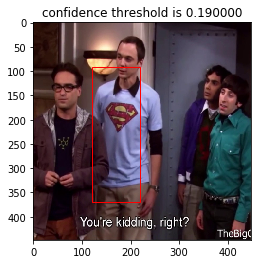

In [49]:
k = 250
draw_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.19, k)

4. save all images with predicted bounding box

In [13]:
print(np.percentile(confidence, 95))

0.13473755121231062


In [45]:
# if not using the whole video, choose the range of frames and update num_frames accordingly
# num_frames: index of the last frame
num_frames = 1000

for k in range(num_frames): 
    save_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.17, k, pathout)

frame 0 done
frame 1 done
frame 2 done
frame 3 done
frame 4 done
frame 5 done
frame 6 done
frame 7 done
frame 8 done
frame 9 done
frame 10 done
frame 11 done
frame 12 done
frame 13 done
frame 14 done
frame 15 done
frame 16 done
frame 17 done
frame 18 done
frame 19 done
frame 20 done
frame 21 done
frame 22 done
frame 23 done
frame 24 done
frame 25 done
frame 26 done
frame 27 done
frame 28 done
frame 29 done
frame 30 done
frame 31 done
frame 32 done
frame 33 done
frame 34 done
frame 35 done
frame 36 done
frame 37 done
frame 38 done
frame 39 done
frame 40 done
frame 41 done
frame 42 done
frame 43 done
frame 44 done
frame 45 done
frame 46 done
frame 47 done
frame 48 done
frame 49 done
frame 50 done
frame 51 done
frame 52 done
frame 53 done
frame 54 done
frame 55 done
frame 56 done
frame 57 done
frame 58 done
frame 59 done
frame 60 done
frame 61 done
frame 62 done
frame 63 done
frame 64 done
frame 65 done
frame 66 done
frame 67 done
frame 68 done
frame 69 done
frame 70 done
frame 71 done
fr

frame 554 done
frame 555 done
frame 556 done
frame 557 done
frame 558 done
frame 559 done
frame 560 done
frame 561 done
frame 562 done
frame 563 done
frame 564 done
frame 565 done
frame 566 done
frame 567 done
frame 568 done
frame 569 done
frame 570 done
frame 571 done
frame 572 done
frame 573 done
frame 574 done
frame 575 done
frame 576 done
frame 577 done
frame 578 done
frame 579 done
frame 580 done
frame 581 done
frame 582 done
frame 583 done
frame 584 done
frame 585 done
frame 586 done
frame 587 done
frame 588 done
frame 589 done
frame 590 done
frame 591 done
frame 592 done
frame 593 done
frame 594 done
frame 595 done
frame 596 done
frame 597 done
frame 598 done
frame 599 done
frame 600 done
frame 601 done
frame 602 done
frame 603 done
frame 604 done
frame 605 done
frame 606 done
frame 607 done
frame 608 done
frame 609 done
frame 610 done
frame 611 done
frame 612 done
frame 613 done
frame 614 done
frame 615 done
frame 616 done
frame 617 done
frame 618 done
frame 619 done
frame 620 

5. convert predicted images to video

In [46]:
image_to_video(pathout, num_frames) 